
# Jupyter Notebook: JAMB Performance Analysis & Prediction

This notebook details the Exploratory Data Analysis (EDA) and Predictive Modeling
for investigating JAMB failure rates and predicting future performance trends.

- Project Lead: Nelson M.
- Intern: DA_Group_2


## **1. Introduction & Setup**

In [97]:
# This section sets up your environment and loads the necessary data.

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

print("All necessary libraries imported.")


# Set plotting style for better aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6) # Standard figure size
plt.rcParams['figure.dpi'] = 100 # High resolution for plots

print("Plotting style set.")

All necessary libraries imported.
Plotting style set.


####  Load the Cleaned Dataset 

In [98]:
#loading the 'JAMB_Cleaned_Dataset_V2.csv'

try:
    df = pd.read_csv('JAMB_Cleaned_Dataset_V2.csv')
    print("Dataset 'JAMB_Cleaned_Dataset_V2.csv' loaded successfully.")

except FileNotFoundError:
    print("Error: 'JAMB_Cleaned_Dataset_V2.csv' not found.")
    print("Please ensure the data cleaning process was executed successfully and the file was saved in the same directory as this notebook.")
    raise # Re-raise the error to stop execution if file is missing

Dataset 'JAMB_Cleaned_Dataset_V3.csv' loaded successfully.


#### Apply correct dtypes and standardize columns as per the latest revisions 

In [99]:
# Numerical nullable integers
int_cols = ['jamb_attempts_count', 'jamb_year_most_recent', 'jamb_score_most_recent']
for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
print("Integer columns dtypes re-applied.")

Integer columns dtypes re-applied.


In [100]:
# Column: study_hours_per_day: Directly categorical and ordered from CSV
if 'study_hours_per_day' in df.columns:
    study_hours_order = ['<1 hour', '1-2 hours', '2-3 hours', '3-4 hours', '4+ hours'] 
    df['study_hours_per_day'] = pd.Categorical(df['study_hours_per_day'], categories=study_hours_order, ordered=True)
    print(f"Column 'study_hours_per_day' converted to ordered categorical with values: {df['study_hours_per_day'].unique()}")
print("Study hours column dtypes re-applied as ordered categorical.")

Column 'study_hours_per_day' converted to ordered categorical with values: ['3-4 hours', '1-2 hours', '4+ hours', '<1 hour', '2-3 hours']
Categories (5, object): ['<1 hour' < '1-2 hours' < '2-3 hours' < '3-4 hours' < '4+ hours']
Study hours column dtypes re-applied as ordered categorical.


In [101]:
# Column: household_dependents - Directly categorical from CSV, handle NaN and standardize
if 'household_dependents' in df.columns:
    # First, convert to string, remove " dependents", then strip whitespace
    df['household_dependents'] = df['household_dependents'].astype(str).str.replace(' dependents', '').str.strip()
    # Now, explicitly replace 'nan' string from conversion with actual numpy NaN
    df['household_dependents'] = df['household_dependents'].replace('nan', np.nan)
    # Define order including 'Unknown' for later fillna
    household_dependents_order = ['1-2', '3-5', '6-8', '9+', 'Unknown'] # Added Unknown
    # Convert to categorical without filling NaNs yet, but include 'Unknown' in categories
    df['household_dependents'] = pd.Categorical(df['household_dependents'], categories=household_dependents_order, ordered=True)
    print(f"Column 'household_dependents' converted to ordered categorical with values: {df['household_dependents'].unique()}")
print("Household dependents column dtypes re-applied as ordered categorical.")

Column 'household_dependents' converted to ordered categorical with values: [NaN, '1-2', '3-5', '6-8', '9+']
Categories (5, object): ['1-2' < '3-5' < '6-8' < '9+' < 'Unknown']
Household dependents column dtypes re-applied as ordered categorical.


In [102]:
# Column: guardian_education_level - Handle NaN and standardize
if 'guardian_education_level' in df.columns:
    df['guardian_education_level'] = df['guardian_education_level'].astype(str).str.capitalize().str.strip()
    df['guardian_education_level'] = df['guardian_education_level'].replace('Nan', 'Unknown') # 'Nan' from capitalize(np.nan)
    # Consolidate values based on V3 inspection (Primary, Secondary, Tertiary, Unknown)
    edu_level_order_final = ['Unknown', 'Primary', 'Secondary', 'Tertiary']
    df['guardian_education_level'] = pd.Categorical(df['guardian_education_level'], categories=edu_level_order_final, ordered=True)
    print(f"Column 'guardian_education_level' standardized and converted to ordered categorical with values: {df['guardian_education_level'].unique()}")
print("Guardian education level column dtypes re-applied as ordered categorical.")

Column 'guardian_education_level' standardized and converted to ordered categorical with values: ['Tertiary', 'Secondary', 'Primary', 'Unknown']
Categories (4, object): ['Unknown' < 'Primary' < 'Secondary' < 'Tertiary']
Guardian education level column dtypes re-applied as ordered categorical.


In [103]:
# Standardize and convert other specific categorical columns to ordered categories
categorical_cols_to_process = {
    'study_plan_adherence': ['Never', 'Rarely', 'Sometimes', 'Often', 'Always'],
    'internet_reliability': ['No Access', 'Slightly Reliable', 'Moderately Reliable', 'Very Reliable'],
    'quality_of_instruction': ['Very Poor', 'Poor', 'Average', 'Good', 'Excellent'],
    'familiar_with_cbt': ['No', 'Yes']
}

for col, order in categorical_cols_to_process.items():
    if col in df.columns:
        df[col] = df[col].astype(str).str.capitalize().str.strip() # General standardize
        # Specific replacements for internet_reliability and quality_of_instruction to match order
        if col == 'internet_reliability':
            df[col] = df[col].replace({'No access': 'No Access', 'Slightly reliable': 'Slightly Reliable',
                                       'Moderately reliable': 'Moderately Reliable', 'Very reliable': 'Very Reliable'})
        elif col == 'quality_of_instruction':
            df[col] = df[col].replace({'Very poor': 'Very Poor'}) # Ensure consistent 'Very Poor'

        df[col] = pd.Categorical(df[col], categories=order, ordered=True)
        print(f"Column '{col}' standardized and converted to ordered categorical.")
    else:
        print(f"Warning: Column '{col}' not found for specific processing.")
print("Specific categorical columns dtypes re-applied and standardized.")

Column 'study_plan_adherence' standardized and converted to ordered categorical.
Column 'internet_reliability' standardized and converted to ordered categorical.
Column 'quality_of_instruction' standardized and converted to ordered categorical.
Column 'familiar_with_cbt' standardized and converted to ordered categorical.
Specific categorical columns dtypes re-applied and standardized.


In [104]:
# Other general categorical columns (those not explicitly ordered above, and not numerical or processed)
general_categorical_cols = [
    'school_type', 'school_location', 'gender', 'age_when_took_jamb',
    'attended_extra_tutorials', 'consistent_study_schedule',
    'access_to_computer_smartphone', 'access_to_textbooks',
    'electricity_consistency', 'arrived_early_exam_center'
    # 'study_resources' is object, will be handled by get_dummies.
    # 'biggest_challenge' and 'advice_to_future_candidate' are text/object, will be excluded.
]
for col in general_categorical_cols:
    if col in df.columns and not isinstance(df[col].dtype, pd.CategoricalDtype): # Check if already categorized
        df[col] = df[col].astype('category')
print("General categorical columns dtypes re-applied.")

General categorical columns dtypes re-applied.


In [105]:
#Display the first few rows of the dataset
print("First 5 rows of the dataset after initial setup and ALL revised column processing:")
print(df.head())

First 5 rows of the dataset after initial setup and ALL revised column processing:
   student_id  jamb_attempts_count  jamb_year_most_recent  \
0           1                    4                   2025   
1           2                    1                   2022   
2           3                    2                   2022   
3           4                    1                   2022   
4           5                    1                   2022   

   jamb_score_most_recent        school_type school_location  gender  \
0                     219            Private      Semi-Urban    Male   
1                     204            Private      Semi-Urban  Female   
2                     203  Public/Government      Semi-Urban  Female   
3                     200            Private           Urban  Female   
4                     283  Public/Government           Urban    Male   

  age_when_took_jamb study_hours_per_day  \
0        18-20 years           3-4 hours   
1        21-23 years         

In [106]:
# Display general information about the dataset (data types, non-null counts)
print("\nInformation about the dataset after initial setup and ALL revised column processing:")
print(df.info())


Information about the dataset after initial setup and ALL revised column processing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   student_id                     450 non-null    int64   
 1   jamb_attempts_count            450 non-null    Int64   
 2   jamb_year_most_recent          450 non-null    Int64   
 3   jamb_score_most_recent         450 non-null    Int64   
 4   school_type                    450 non-null    category
 5   school_location                450 non-null    category
 6   gender                         450 non-null    category
 7   age_when_took_jamb             450 non-null    category
 8   study_hours_per_day            450 non-null    category
 9   study_resources                450 non-null    object  
 10  attended_extra_tutorials       450 non-null    category
 11  consistent_

In [107]:
# List all columns in the dataset to verify names
print("\nAll columns in the dataset after initial setup and ALL revised column processing:")
print(df.columns.tolist())


All columns in the dataset after initial setup and ALL revised column processing:
['student_id', 'jamb_attempts_count', 'jamb_year_most_recent', 'jamb_score_most_recent', 'school_type', 'school_location', 'gender', 'age_when_took_jamb', 'study_hours_per_day', 'study_resources', 'attended_extra_tutorials', 'consistent_study_schedule', 'study_plan_adherence', 'guardian_education_level', 'access_to_computer_smartphone', 'household_dependents', 'internet_reliability', 'access_to_textbooks', 'electricity_consistency', 'quality_of_instruction', 'familiar_with_cbt', 'arrived_early_exam_center', 'biggest_challenge', 'advice_to_future_candidate']


## **2. Exploratory Data Analysis (EDA)**

This section of the notebook performs a comprehensive Exploratory Data Analysis (EDA) to understand the dataset's characteristics and uncover initial insights into JAMB performance.

### 2.1 Define JAMB Success Tiers

Here, we implement the detailed tiered success definition 

In [108]:
# Define tiered success categories 
def categorize_jamb_score(score):
    if score >= 260:
        return 'Tier 1: Elite Success (>=260)'
    elif 220 <= score <= 259:
        return 'Tier 2: Competitive Success (220-259)'
    elif 180 <= score <= 219:
        return 'Tier 3: Foundational Success (180-219)'
    elif 140 <= score <= 179:
        return 'Tier 4: Marginal Success (140-179)'
    else: # Scores below 140
        return 'Failure (<140)'

df['exam_outcome_tiered'] = df['jamb_score_most_recent'].apply(categorize_jamb_score)

# Define the order for the tiers for consistent plotting and reporting 
tier_order = [
    'Tier 1: Elite Success (>=260)',
    'Tier 2: Competitive Success (220-259)',
    'Tier 3: Foundational Success (180-219)',
    'Tier 4: Marginal Success (140-179)',
    'Failure (<140)'
]
# Convert to ordered categorical
df['exam_outcome_tiered'] = pd.Categorical(df['exam_outcome_tiered'], categories=tier_order, ordered=True)


print("Target variable 'exam_outcome_tiered' defined and ordered.")
print(f"Value counts for 'exam_outcome_tiered':\n{df['exam_outcome_tiered'].value_counts(dropna=False)}")

Target variable 'exam_outcome_tiered' defined and ordered.
Value counts for 'exam_outcome_tiered':
exam_outcome_tiered
Tier 4: Marginal Success (140-179)        128
Tier 3: Foundational Success (180-219)    126
Failure (<140)                             87
Tier 2: Competitive Success (220-259)      82
Tier 1: Elite Success (>=260)              27
Name: count, dtype: int64


### 2.2 Overall Success Tier Distribution
This section quantifies the overall performance of students across all years in your dataset.


Overall JAMB Success Tier Distribution (%):
exam_outcome_tiered
Tier 1: Elite Success (>=260)              6.000000
Tier 2: Competitive Success (220-259)     18.222222
Tier 3: Foundational Success (180-219)    28.000000
Tier 4: Marginal Success (140-179)        28.444444
Failure (<140)                            19.333333
Name: proportion, dtype: float64


C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\4006352708.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=overall_tier_distribution.index, y=overall_tier_distribution.values,


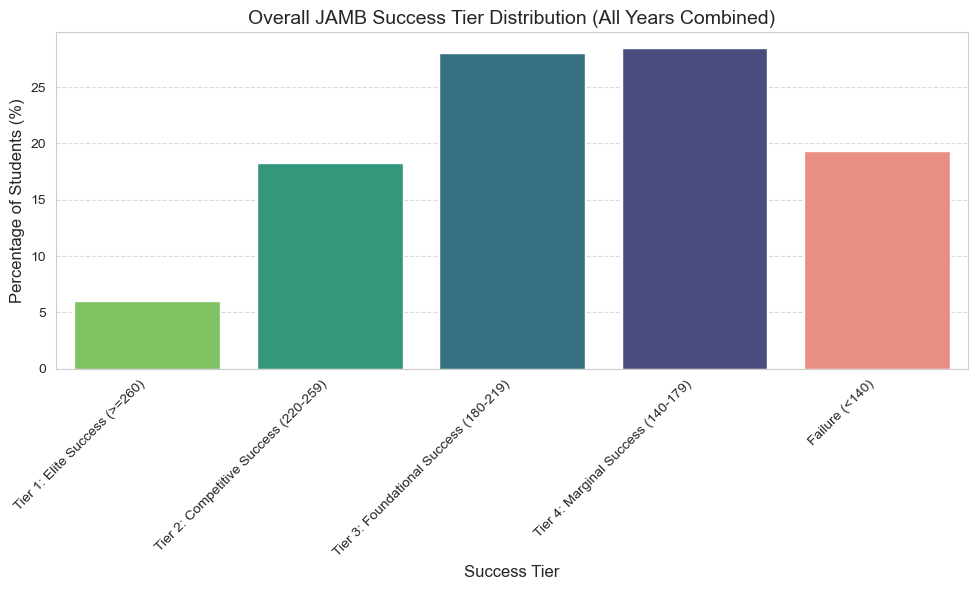

In [109]:
# --- Calculate Overall Success Tier Distribution ---
overall_tier_distribution = df['exam_outcome_tiered'].value_counts(normalize=True).sort_index() * 100

print("\nOverall JAMB Success Tier Distribution (%):")
print(overall_tier_distribution)

# --- Define custom colors for tiered plot based on user's request:
# viridis_r shades for success (Tier 1-3) and Marginal (Tier 4), salmon for Failure.
viridis_shades = sns.color_palette("viridis_r", n_colors=4) # Get 4 shades from viridis_r

colors_tiered_new = {
    'Tier 1: Elite Success (>=260)': viridis_shades[0],
    'Tier 2: Competitive Success (220-259)': viridis_shades[1],
    'Tier 3: Foundational Success (180-219)': viridis_shades[2],
    'Tier 4: Marginal Success (140-179)': viridis_shades[3], # Marginal tier also a viridis shade
    'Failure (<140)': 'salmon' # Failure is salmon
}

# --- Visualize Overall Tier Distribution ---
plt.figure(figsize=(10, 6))
# Ensure the color order matches the tier_order
sns.barplot(x=overall_tier_distribution.index, y=overall_tier_distribution.values,
            palette=[colors_tiered_new[tier] for tier in overall_tier_distribution.index])
plt.title('Overall JAMB Success Tier Distribution (All Years Combined)', fontsize=14)
plt.xlabel('Success Tier', fontsize=12)
plt.ylabel('Percentage of Students (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 2.3 Yearly Success Tier Distribution
This section helps identify trends in JAMB performance over the years.

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3216179637.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_by_year_tiered = df.groupby(['jamb_year_most_recent', 'exam_outcome_tiered']).size().unstack(fill_value=0)



Proportion of Tiered Exam Outcomes by Year:
exam_outcome_tiered    Tier 1: Elite Success (>=260)  \
jamb_year_most_recent                                  
2020                                        0.084507   
2021                                        0.044444   
2022                                        0.033898   
2023                                        0.050633   
2024                                        0.059603   
2025                                        0.088889   

exam_outcome_tiered    Tier 2: Competitive Success (220-259)  \
jamb_year_most_recent                                          
2020                                                0.253521   
2021                                                0.200000   
2022                                                0.169492   
2023                                                0.189873   
2024                                                0.139073   
2025                                                0.2000

<Figure size 1200x700 with 0 Axes>

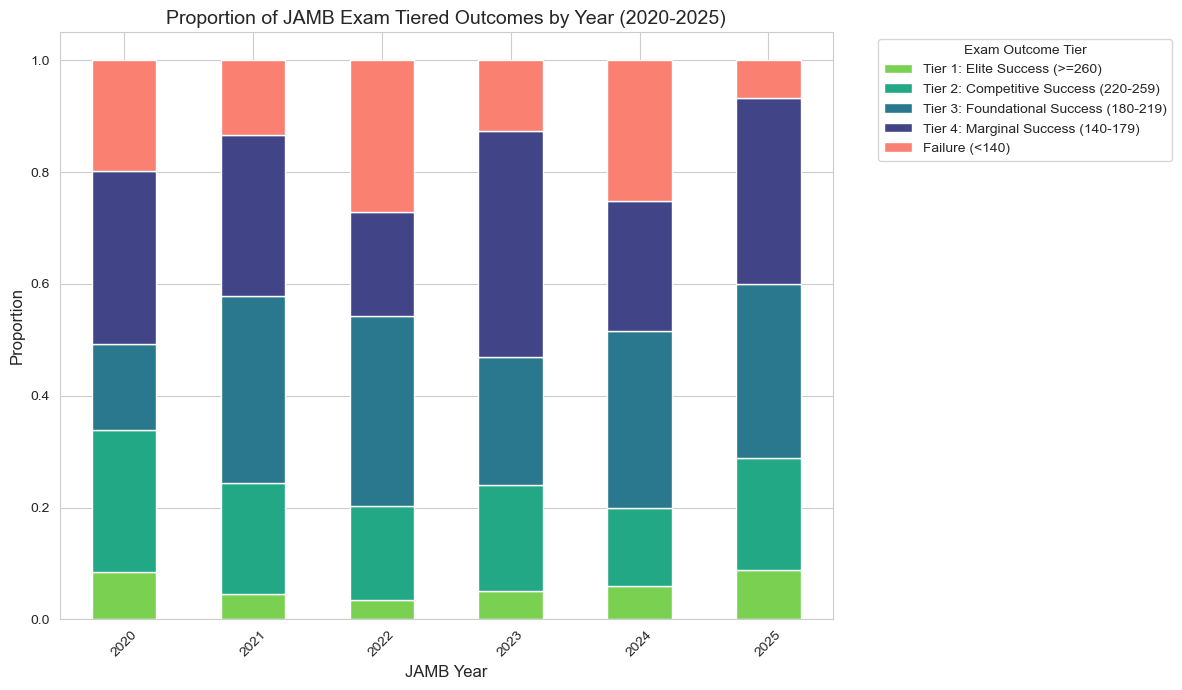

In [110]:
# --- Quantify tiered success/failure rates across years  ---
outcome_by_year_tiered = df.groupby(['jamb_year_most_recent', 'exam_outcome_tiered']).size().unstack(fill_value=0)
outcome_by_year_tiered = outcome_by_year_tiered.reindex(columns=tier_order, fill_value=0) # Ensure all tiers are present

outcome_by_year_tiered_proportions = outcome_by_year_tiered.apply(lambda x: x / x.sum(), axis=1)

print("\nProportion of Tiered Exam Outcomes by Year:")
print(outcome_by_year_tiered_proportions)

# --- Plotting the tiered proportions over years  ---
plt.figure(figsize=(12, 7))
outcome_by_year_tiered_proportions.plot(
    kind='bar', stacked=True, figsize=(12, 7),
    color=[colors_tiered_new[col] for col in outcome_by_year_tiered_proportions.columns] # Use new color palette
)
plt.title('Proportion of JAMB Exam Tiered Outcomes by Year (2020-2025)', fontsize=14)
plt.xlabel('JAMB Year', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Exam Outcome Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('jamb_exam_tiered_outcome_proportions_by_year.png')
plt.show()

### 2.4 Analysis of Factors vs. Tiered Outcomes (using analyze_categorical_vs_tiered_outcome function)
 This section explores how demographic characteristics, study habits, and resource access relate to JAMB success.

In [111]:
# --- Function to analyze and plot proportions for a given categorical column against 'exam_outcome_tiered'  ---
def analyze_categorical_vs_tiered_outcome(dataframe, column_name):
    print(f"\nAnalysis of '{column_name}' vs. 'exam_outcome_tiered':")
    
    # Ensure the column is properly categorized and ordered for consistent plotting
    # This block now expects columns to be either CategoricalDtype (from initial load) or object
    # If object, it tries to convert to CategoricalDtype using predefined orders.
    
    if isinstance(dataframe[column_name].dtype, pd.CategoricalDtype):
        # Column is already a CategoricalDtype, assume its order is set during initial load
        pass
    else: # If it's an object/string column, convert to categorical with explicit order if known
        # This part ensures consistency for plotting even if initial load missed an order.
        # It's a fallback for columns that should be ordered but weren't fully set initially.
        data_col_unique_vals = dataframe[column_name].dropna().unique().tolist()
        
        # Apply specific order for plotting if relevant and not already set as ordered categorical
        if column_name == 'age_when_took_jamb':
            order = ['15-17 years', '18-20 years', '21-23 years', '24-25 years'] # Use exact strings from V3 data
        elif column_name == 'guardian_education_level':
            order = ['Unknown', 'Primary', 'Secondary', 'Tertiary'] # Use refined order
        elif column_name == 'access_to_textbooks':
            order = ['No', 'Very few', 'Some of them', 'Most of them', 'Yes, all'] # Example ordering
        elif column_name == 'electricity_consistency':
            order = ['A few days a week', 'Most days', 'Daily'] # Assuming no 'Never' or similar if not in V3
        else:
            order = sorted(data_col_unique_vals, key=str) # Default to alphabetical sort
        
        dataframe[column_name] = pd.Categorical(dataframe[column_name], categories=order, ordered=True)

    outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)
    outcome_counts = outcome_counts.reindex(columns=tier_order, fill_value=0) # Ensure all tiers are present

    outcome_proportions = outcome_counts.apply(lambda x: x / x.sum(), axis=1)
    print("Counts:")
    print(outcome_counts)
    print("\nProportions:")
    print(outcome_proportions)

    plt.figure(figsize=(10, 6))
    outcome_proportions.plot(
        kind='bar', stacked=True, figsize=(10, 6),
        color=[colors_tiered_new[col] for col in outcome_proportions.columns] # Use new color palette
    )
    plt.title(f'Proportion of JAMB Exam Tiered Outcomes by {column_name}', fontsize=14)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Exam Outcome Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'jamb_exam_tiered_outcome_proportions_by_{column_name.lower().replace(" ", "_").replace("–", "_").replace("-", "_")}.png')
    plt.show()

print("\n--- EDA of Factors vs. Tiered Outcomes ---")


--- EDA of Factors vs. Tiered Outcomes ---



Analysis of 'gender' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered  Tier 1: Elite Success (>=260)  \
gender                                               
Female                                          12   
Male                                            15   
Prefer not to say                                0   

exam_outcome_tiered  Tier 2: Competitive Success (220-259)  \
gender                                                       
Female                                                  37   
Male                                                    44   
Prefer not to say                                        1   

exam_outcome_tiered  Tier 3: Foundational Success (180-219)  \
gender                                                        
Female                                                   89   
Male                                                     37   
Prefer not to say                                         0   

exam_outcome_tiered  Tier 4: Marginal Success

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

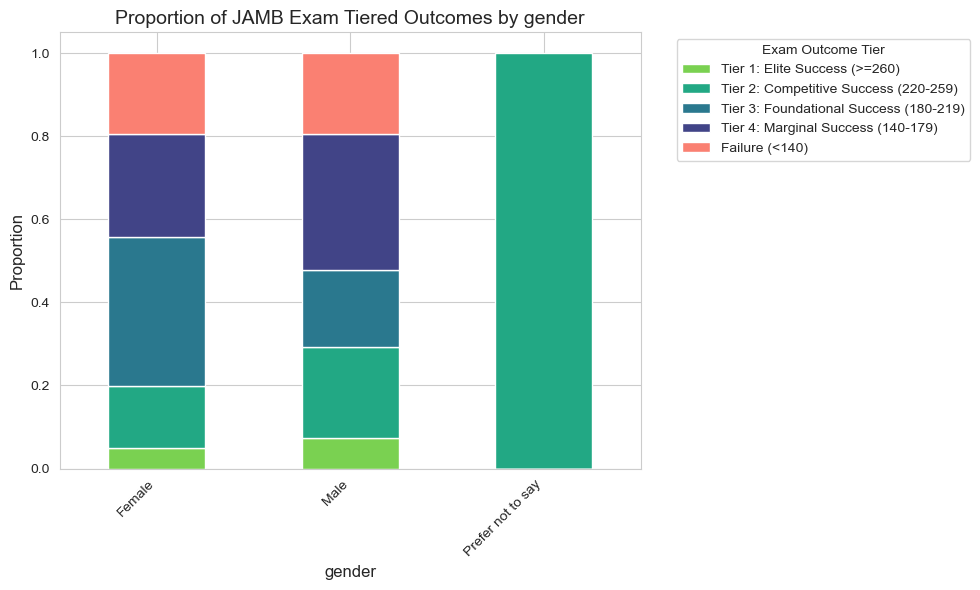


Analysis of 'school_type' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered  Tier 1: Elite Success (>=260)  \
school_type                                          
Mission/Religious                                0   
Other (specify)                                  0   
Private                                          7   
Public                                          16   
Public/Government                                4   

exam_outcome_tiered  Tier 2: Competitive Success (220-259)  \
school_type                                                  
Mission/Religious                                        0   
Other (specify)                                          0   
Private                                                 30   
Public                                                  41   
Public/Government                                       11   

exam_outcome_tiered  Tier 3: Foundational Success (180-219)  \
school_type                                                  

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

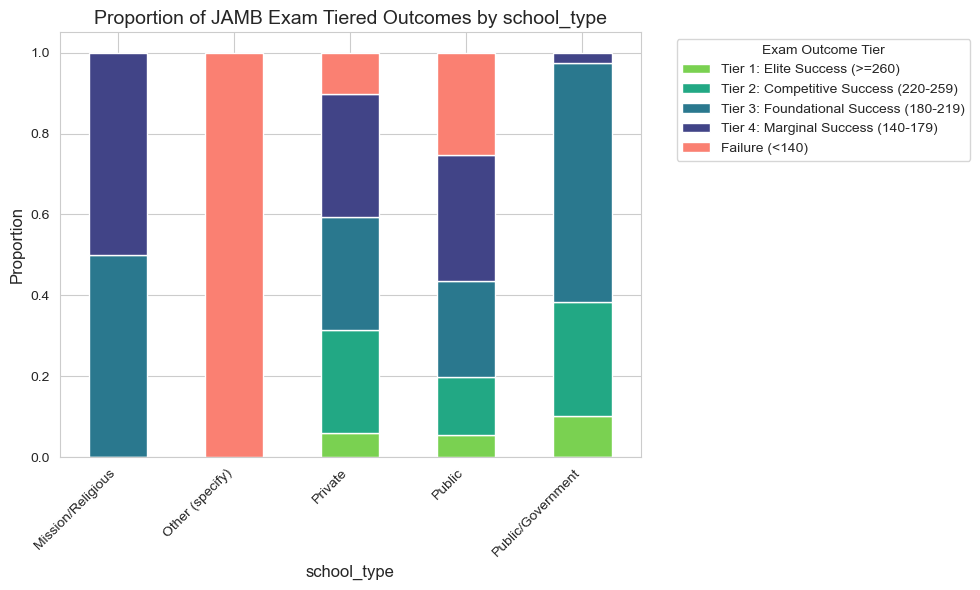


Analysis of 'school_location' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered  Tier 1: Elite Success (>=260)  \
school_location                                      
Rural                                            9   
Semi-Urban                                       0   
Urban                                           18   

exam_outcome_tiered  Tier 2: Competitive Success (220-259)  \
school_location                                              
Rural                                                   28   
Semi-Urban                                               5   
Urban                                                   49   

exam_outcome_tiered  Tier 3: Foundational Success (180-219)  \
school_location                                               
Rural                                                    55   
Semi-Urban                                               10   
Urban                                                    61   

exam_outcome_tiered  Tier 4: Margina

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

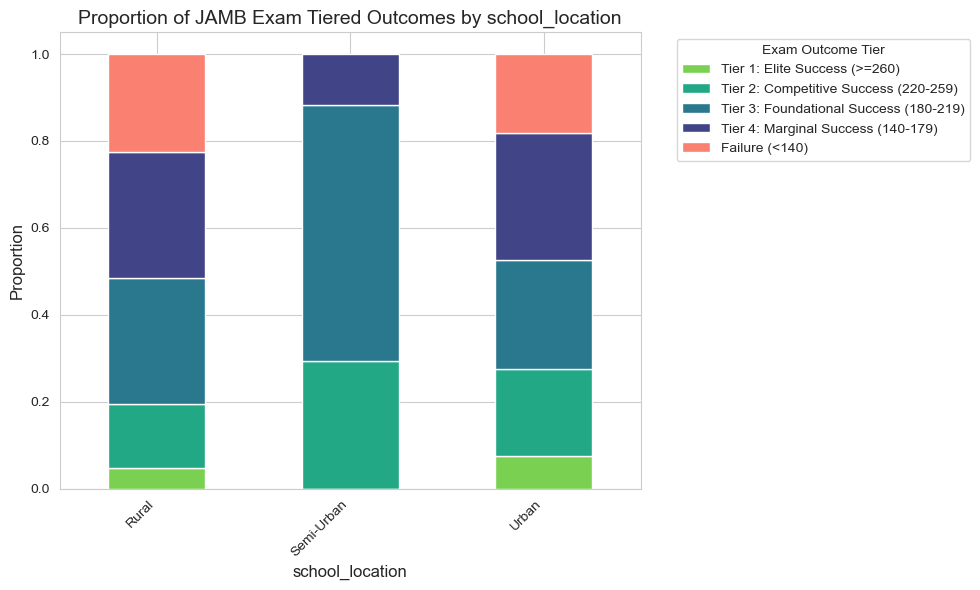


Analysis of 'age_when_took_jamb' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered  Tier 1: Elite Success (>=260)  \
age_when_took_jamb                                   
15-17 years                                     11   
18-20 years                                      9   
21-23 years                                      7   
24-25 years                                      0   

exam_outcome_tiered  Tier 2: Competitive Success (220-259)  \
age_when_took_jamb                                           
15-17 years                                             36   
18-20 years                                             28   
21-23 years                                             18   
24-25 years                                              0   

exam_outcome_tiered  Tier 3: Foundational Success (180-219)  \
age_when_took_jamb                                            
15-17 years                                              52   
18-20 years                                 

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

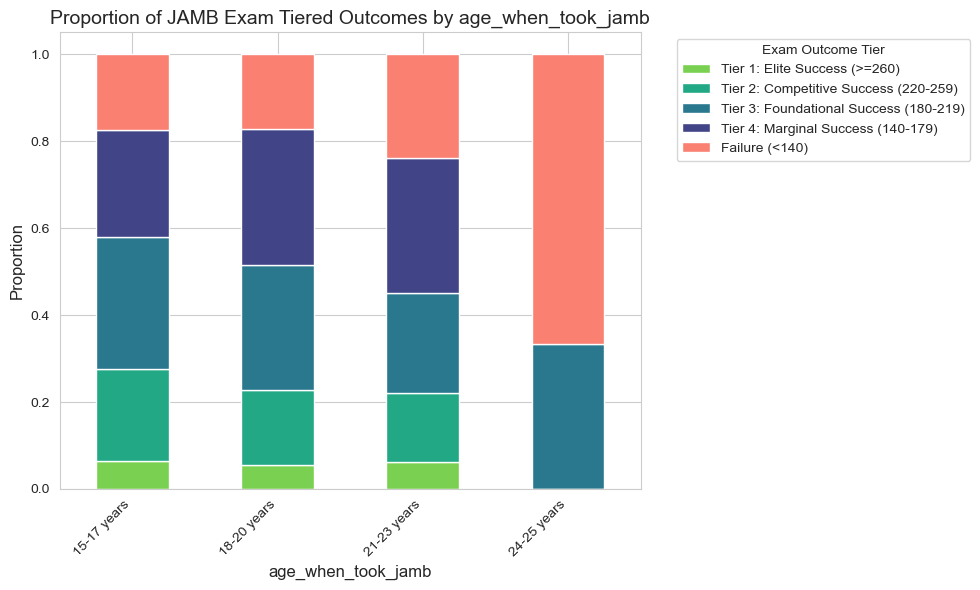

In [112]:
# --- Demographics ---
analyze_categorical_vs_tiered_outcome(df, 'gender')
analyze_categorical_vs_tiered_outcome(df, 'school_type') 
analyze_categorical_vs_tiered_outcome(df, 'school_location')
analyze_categorical_vs_tiered_outcome(df, 'age_when_took_jamb')


Analysis of 'study_hours_per_day' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered  Tier 1: Elite Success (>=260)  \
study_hours_per_day                                  
<1 hour                                          0   
1-2 hours                                        1   
2-3 hours                                        5   
3-4 hours                                       10   
4+ hours                                        11   

exam_outcome_tiered  Tier 2: Competitive Success (220-259)  \
study_hours_per_day                                          
<1 hour                                                  4   
1-2 hours                                               15   
2-3 hours                                               19   
3-4 hours                                               24   
4+ hours                                                20   

exam_outcome_tiered  Tier 3: Foundational Success (180-219)  \
study_hours_per_day                                  

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

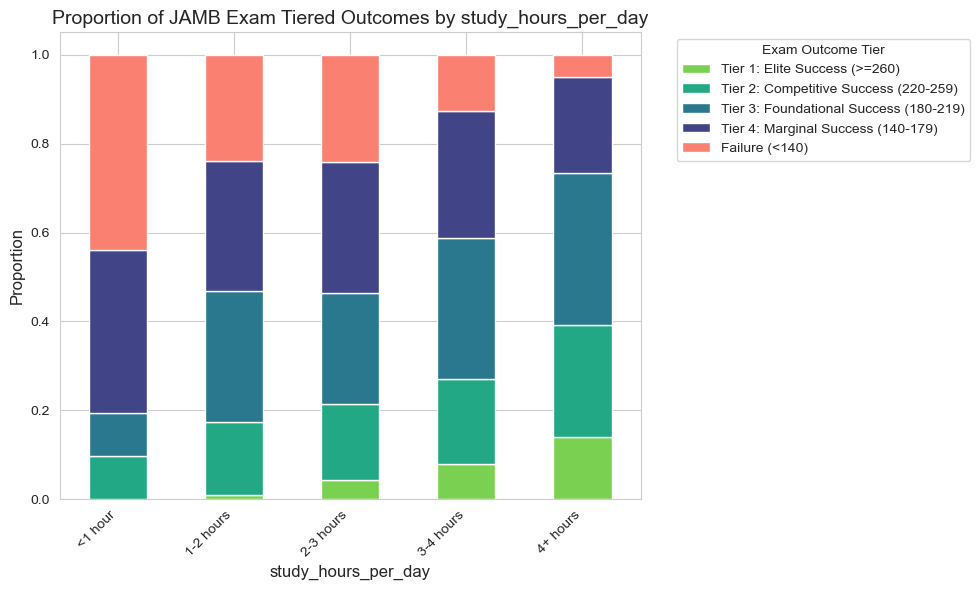


Analysis of 'attended_extra_tutorials' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered       Tier 1: Elite Success (>=260)  \
attended_extra_tutorials                                  
No                                                    6   
Yes                                                  21   

exam_outcome_tiered       Tier 2: Competitive Success (220-259)  \
attended_extra_tutorials                                          
No                                                           32   
Yes                                                          50   

exam_outcome_tiered       Tier 3: Foundational Success (180-219)  \
attended_extra_tutorials                                           
No                                                            55   
Yes                                                           71   

exam_outcome_tiered       Tier 4: Marginal Success (140-179)  Failure (<140)  
attended_extra_tutorials                                           

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

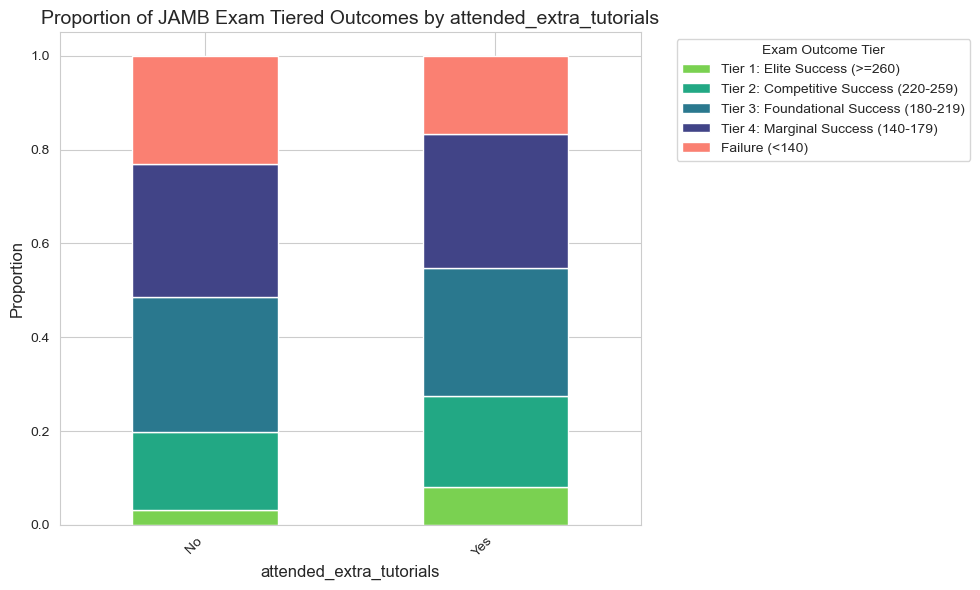


Analysis of 'consistent_study_schedule' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered        Tier 1: Elite Success (>=260)  \
consistent_study_schedule                                  
No                                                     7   
Sometimes                                              3   
Yes                                                   17   

exam_outcome_tiered        Tier 2: Competitive Success (220-259)  \
consistent_study_schedule                                          
No                                                            12   
Sometimes                                                     31   
Yes                                                           39   

exam_outcome_tiered        Tier 3: Foundational Success (180-219)  \
consistent_study_schedule                                           
No                                                             27   
Sometimes                                                      41   
Yes   

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

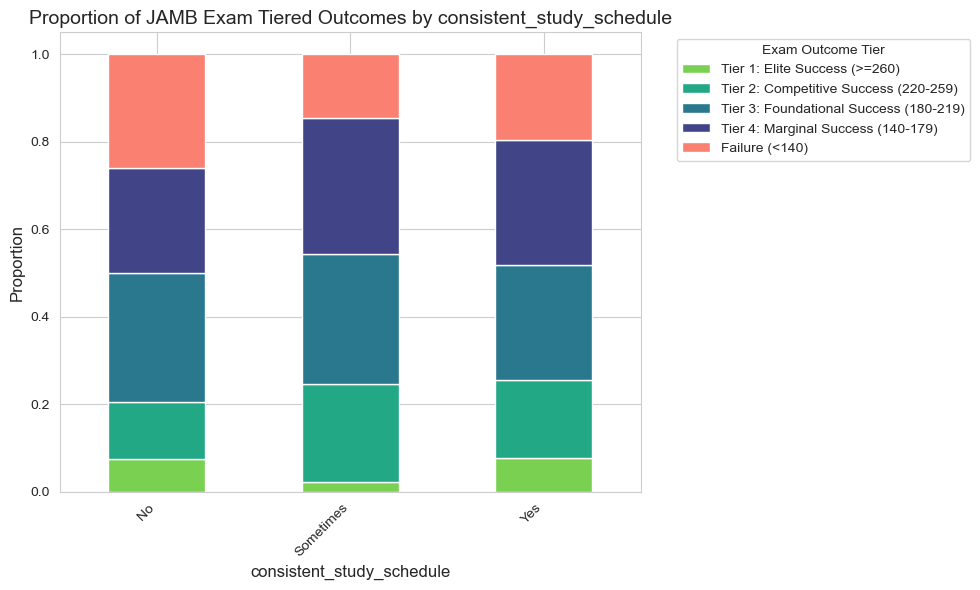


Analysis of 'study_plan_adherence' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered   Tier 1: Elite Success (>=260)  \
study_plan_adherence                                  
Never                                             0   
Rarely                                            0   
Sometimes                                         0   
Often                                            10   
Always                                           17   

exam_outcome_tiered   Tier 2: Competitive Success (220-259)  \
study_plan_adherence                                          
Never                                                     1   
Rarely                                                    0   
Sometimes                                                 5   
Often                                                    43   
Always                                                   33   

exam_outcome_tiered   Tier 3: Foundational Success (180-219)  \
study_plan_adherence                 

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

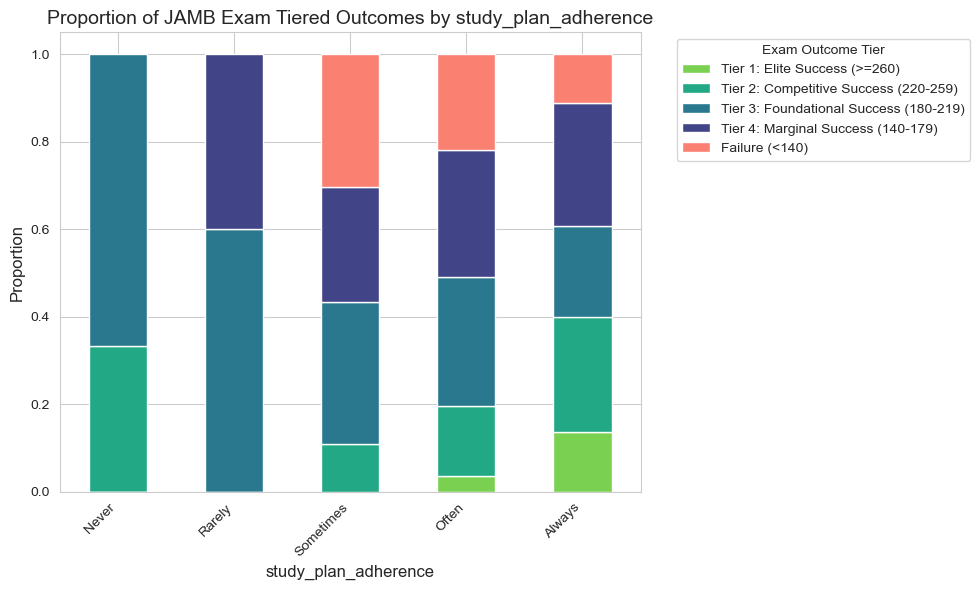


Analysis of 'quality_of_instruction' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered     Tier 1: Elite Success (>=260)  \
quality_of_instruction                                  
Very Poor                                           0   
Poor                                                2   
Average                                            17   
Good                                                5   
Excellent                                           3   

exam_outcome_tiered     Tier 2: Competitive Success (220-259)  \
quality_of_instruction                                          
Very Poor                                                   7   
Poor                                                       15   
Average                                                    26   
Good                                                       27   
Excellent                                                   7   

exam_outcome_tiered     Tier 3: Foundational Success (180-219)  \
quali

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

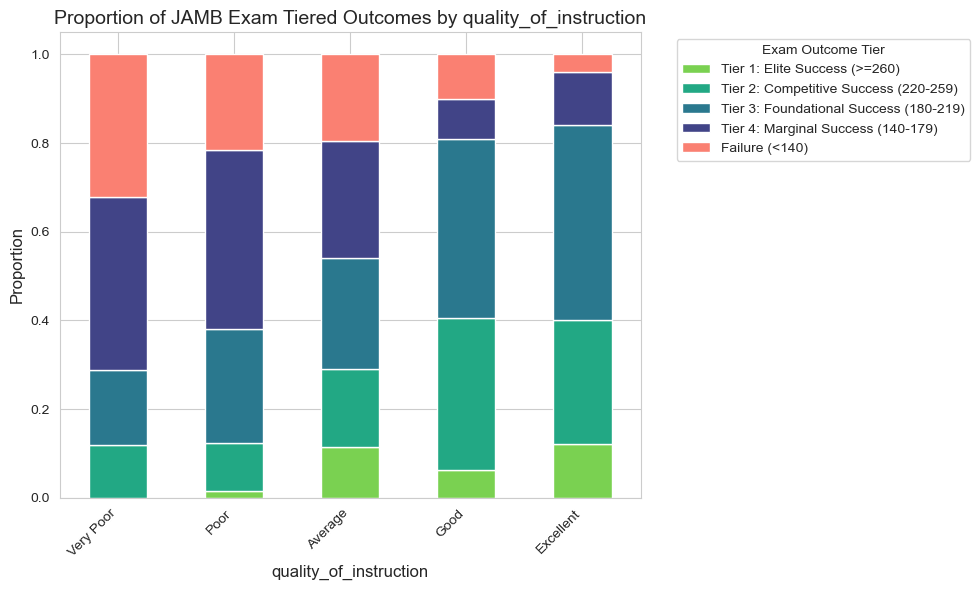


Analysis of 'familiar_with_cbt' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered  Tier 1: Elite Success (>=260)  \
familiar_with_cbt                                    
No                                               9   
Yes                                             18   

exam_outcome_tiered  Tier 2: Competitive Success (220-259)  \
familiar_with_cbt                                            
No                                                      20   
Yes                                                     62   

exam_outcome_tiered  Tier 3: Foundational Success (180-219)  \
familiar_with_cbt                                             
No                                                       43   
Yes                                                      83   

exam_outcome_tiered  Tier 4: Marginal Success (140-179)  Failure (<140)  
familiar_with_cbt                                                        
No                                                   41          

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

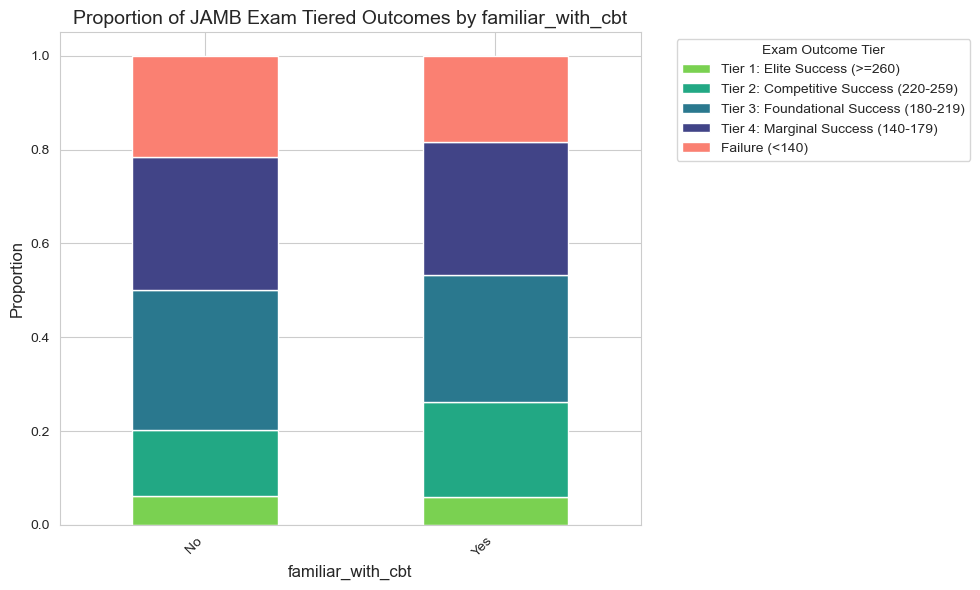


Analysis of 'arrived_early_exam_center' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered        Tier 1: Elite Success (>=260)  \
arrived_early_exam_center                                  
Yes, a little early                                   11   
Yes, significantly early                              16   

exam_outcome_tiered        Tier 2: Competitive Success (220-259)  \
arrived_early_exam_center                                          
Yes, a little early                                           36   
Yes, significantly early                                      46   

exam_outcome_tiered        Tier 3: Foundational Success (180-219)  \
arrived_early_exam_center                                           
Yes, a little early                                            65   
Yes, significantly early                                       61   

exam_outcome_tiered        Tier 4: Marginal Success (140-179)  Failure (<140)  
arrived_early_exam_center                            

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

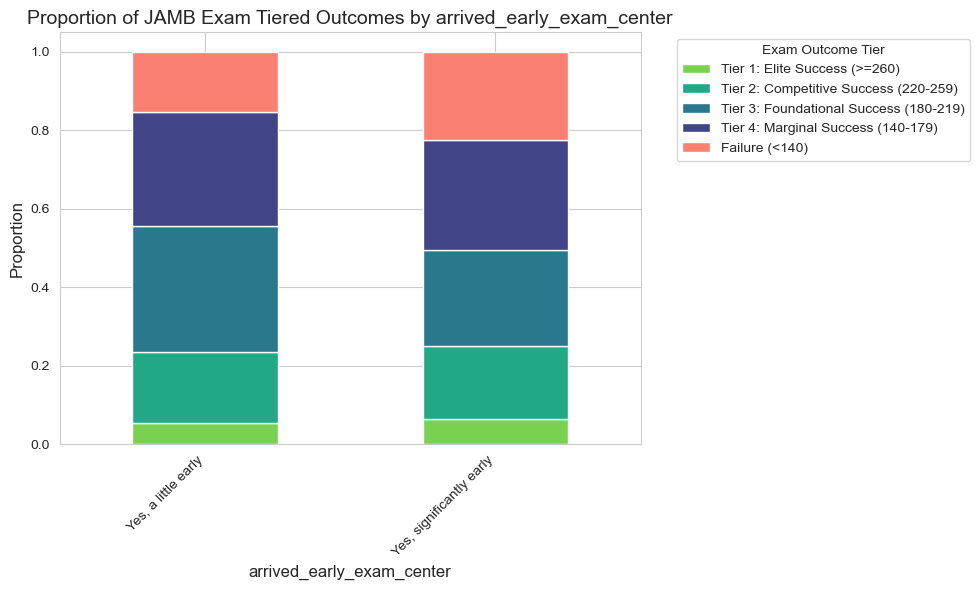

In [113]:
# --- Study Habits & Resources ---
analyze_categorical_vs_tiered_outcome(df, 'study_hours_per_day')
analyze_categorical_vs_tiered_outcome(df, 'attended_extra_tutorials')
analyze_categorical_vs_tiered_outcome(df, 'consistent_study_schedule')
analyze_categorical_vs_tiered_outcome(df, 'study_plan_adherence')
analyze_categorical_vs_tiered_outcome(df, 'quality_of_instruction')
analyze_categorical_vs_tiered_outcome(df, 'familiar_with_cbt')
analyze_categorical_vs_tiered_outcome(df, 'arrived_early_exam_center')


Analysis of 'access_to_computer_smartphone' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered            Tier 1: Elite Success (>=260)  \
access_to_computer_smartphone                                  
No                                                        11   
Yes                                                       16   

exam_outcome_tiered            Tier 2: Competitive Success (220-259)  \
access_to_computer_smartphone                                          
No                                                                35   
Yes                                                               47   

exam_outcome_tiered            Tier 3: Foundational Success (180-219)  \
access_to_computer_smartphone                                           
No                                                                 44   
Yes                                                                82   

exam_outcome_tiered            Tier 4: Marginal Success (140-179)  \
access_to_co

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

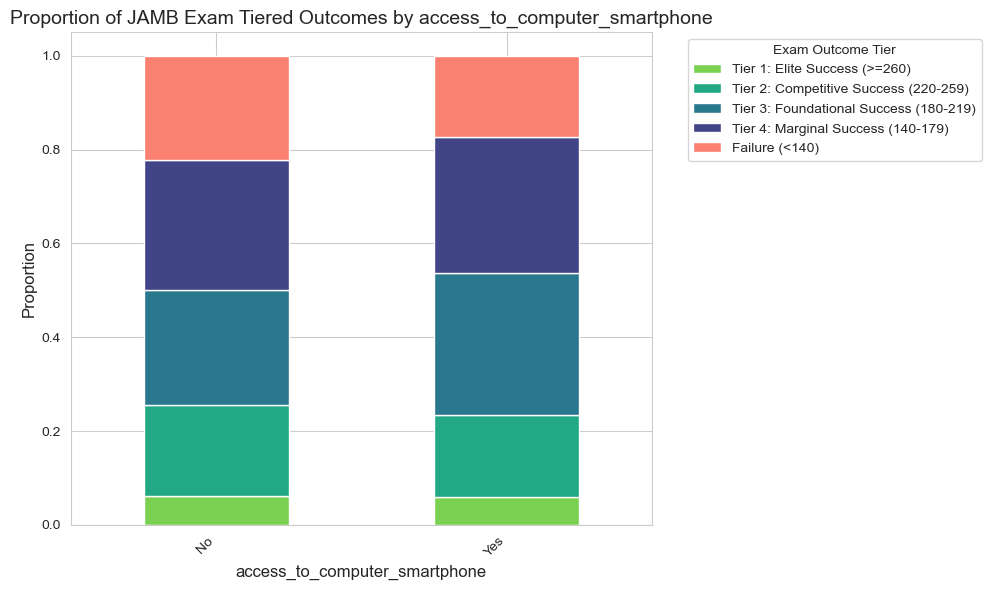


Analysis of 'internet_reliability' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered   Tier 1: Elite Success (>=260)  \
internet_reliability                                  
No Access                                         4   
Slightly Reliable                                 6   
Moderately Reliable                              12   
Very Reliable                                     5   

exam_outcome_tiered   Tier 2: Competitive Success (220-259)  \
internet_reliability                                          
No Access                                                11   
Slightly Reliable                                        20   
Moderately Reliable                                      31   
Very Reliable                                            20   

exam_outcome_tiered   Tier 3: Foundational Success (180-219)  \
internet_reliability                                           
No Access                                                 12   
Slightly Reliable          

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

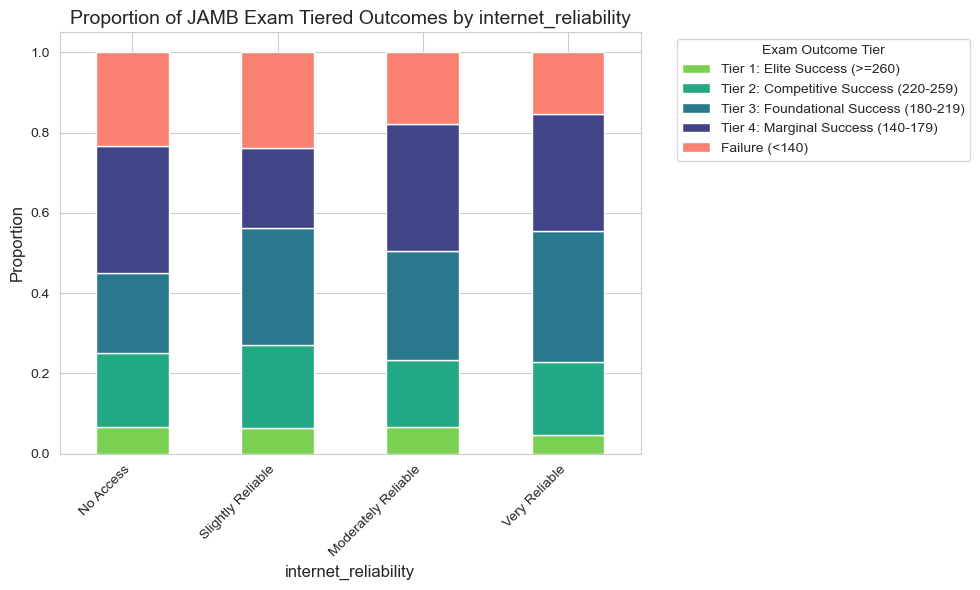


Analysis of 'access_to_textbooks' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered  Tier 1: Elite Success (>=260)  \
access_to_textbooks                                  
Most of them                                     9   
No                                               1   
Some of them                                     9   
Very few                                         2   
Yes, all                                         6   

exam_outcome_tiered  Tier 2: Competitive Success (220-259)  \
access_to_textbooks                                          
Most of them                                            15   
No                                                       9   
Some of them                                            30   
Very few                                                 4   
Yes, all                                                24   

exam_outcome_tiered  Tier 3: Foundational Success (180-219)  \
access_to_textbooks                                  

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

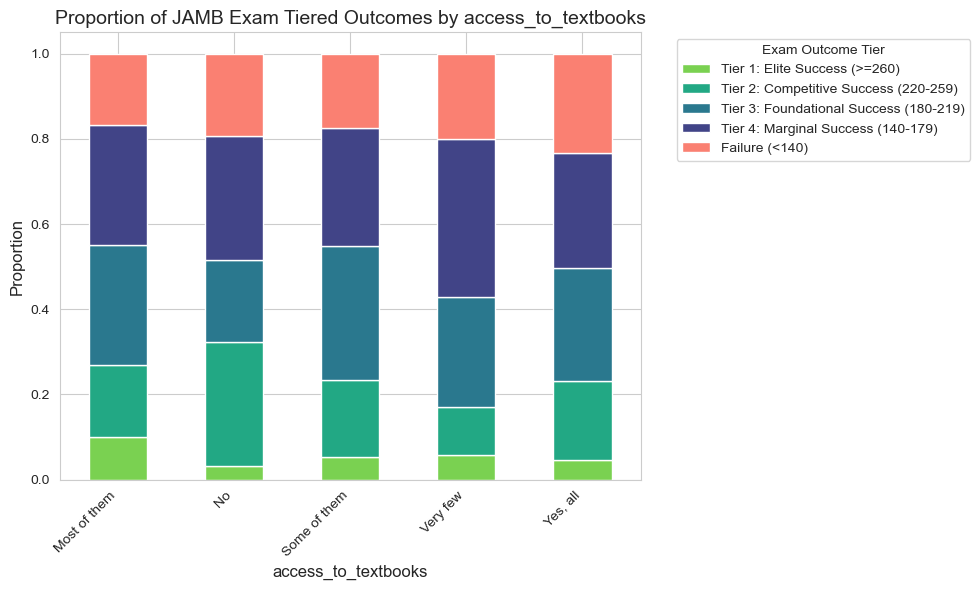


Analysis of 'electricity_consistency' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered      Tier 1: Elite Success (>=260)  \
electricity_consistency                                  
A few days a week                                    8   
Daily                                                4   
Most days                                           11   
Never                                                0   
Rarely                                               4   

exam_outcome_tiered      Tier 2: Competitive Success (220-259)  \
electricity_consistency                                          
A few days a week                                           17   
Daily                                                       19   
Most days                                                   29   
Never                                                        1   
Rarely                                                      16   

exam_outcome_tiered      Tier 3: Foundational Success (1

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

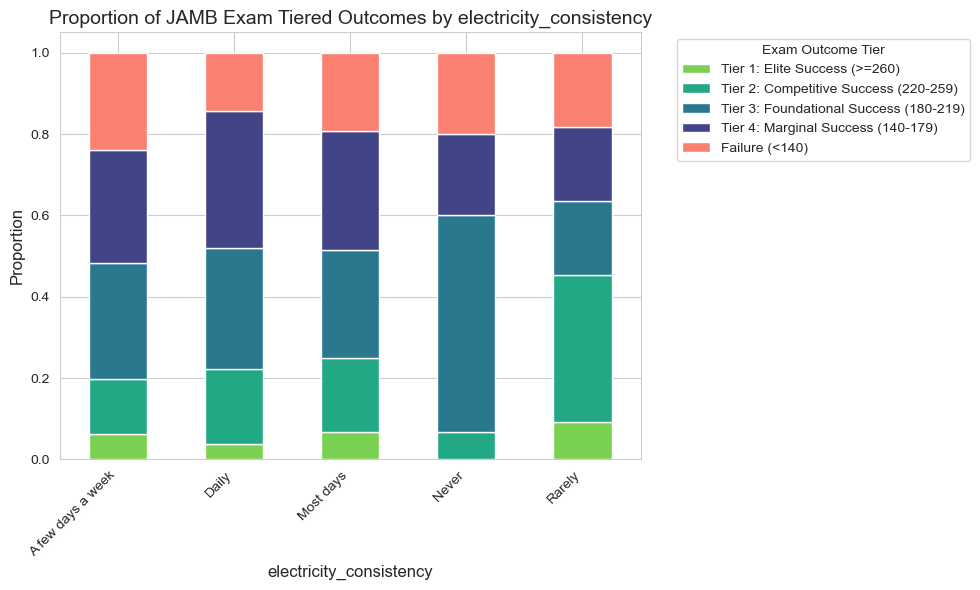

In [114]:
# --- Access to Resources ---
analyze_categorical_vs_tiered_outcome(df, 'access_to_computer_smartphone')
analyze_categorical_vs_tiered_outcome(df, 'internet_reliability')
analyze_categorical_vs_tiered_outcome(df, 'access_to_textbooks')
analyze_categorical_vs_tiered_outcome(df, 'electricity_consistency')


Analysis of 'guardian_education_level' vs. 'exam_outcome_tiered':

Analysis of 'guardian_education_level' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered       Tier 1: Elite Success (>=260)  \
guardian_education_level                                  
Unknown                                               1   
Primary                                               4   
Secondary                                            10   
Tertiary                                             12   

exam_outcome_tiered       Tier 2: Competitive Success (220-259)  \
guardian_education_level                                          
Unknown                                                       8   
Primary                                                      19   
Secondary                                                    25   
Tertiary                                                     30   

exam_outcome_tiered       Tier 3: Foundational Success (180-219)  \
guardian_education_level        

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

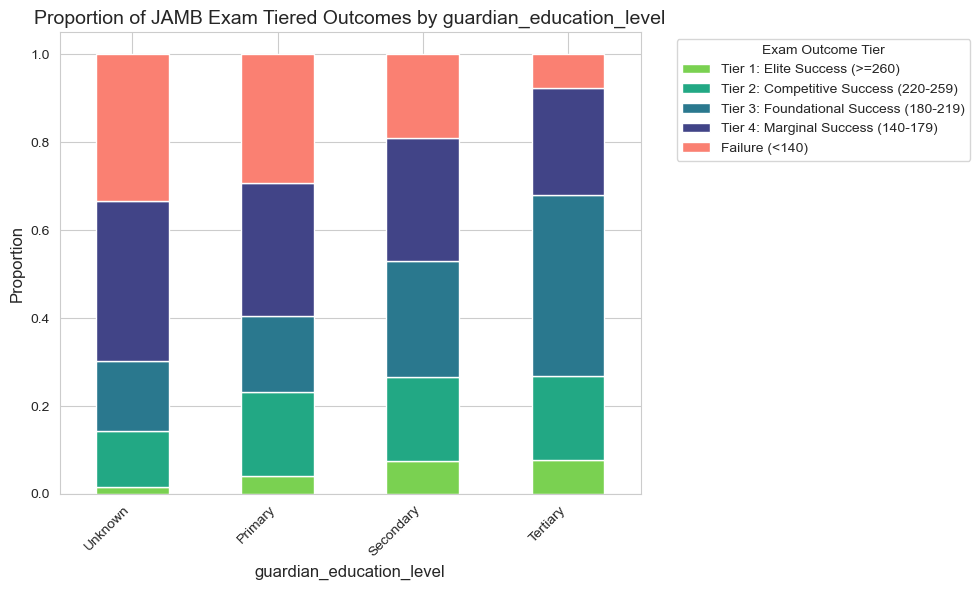


Analysis of 'household_dependents' vs. 'exam_outcome_tiered':

Analysis of 'household_dependents' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered   Tier 1: Elite Success (>=260)  \
household_dependents                                  
1-2                                               5   
3-5                                              15   
6-8                                               6   
9+                                                1   
Unknown                                           0   

exam_outcome_tiered   Tier 2: Competitive Success (220-259)  \
household_dependents                                          
1-2                                                      16   
3-5                                                      34   
6-8                                                      19   
9+                                                        8   
Unknown                                                   5   

exam_outcome_tiered   Tier 3: Foundati

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

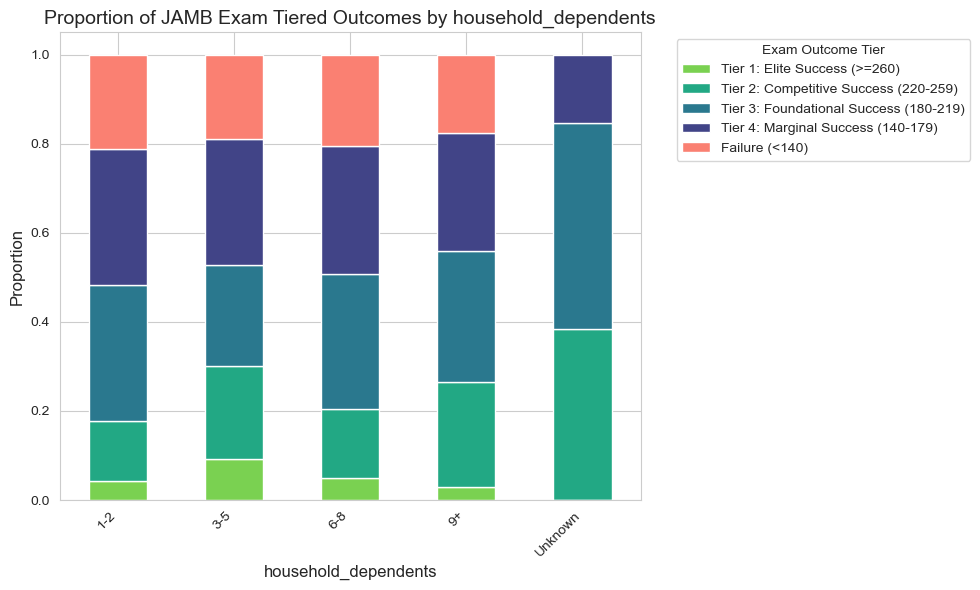


Analysis of 'study_resources' vs. 'exam_outcome_tiered':

Analysis of 'study_resources' vs. 'exam_outcome_tiered':
Counts:
exam_outcome_tiered                                 Tier 1: Elite Success (>=260)  \
study_resources                                                                     
Online tutorials/videos                                                         0   
Past questions                                                                  2   
Past questions, Online tutorials/videos                                         0   
Past questions, Online tutorials/videos, Physic...                              2   
Past questions, Online tutorials/videos, Physic...                              1   
Past questions, Physical tutorials/coaching cen...                              1   
Past questions, Physical tutorials/coaching cen...                              0   
Past questions, Private lessons                                                 0   
Past questions, Textbooks 

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3554708214.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_counts = dataframe.groupby([column_name, 'exam_outcome_tiered']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

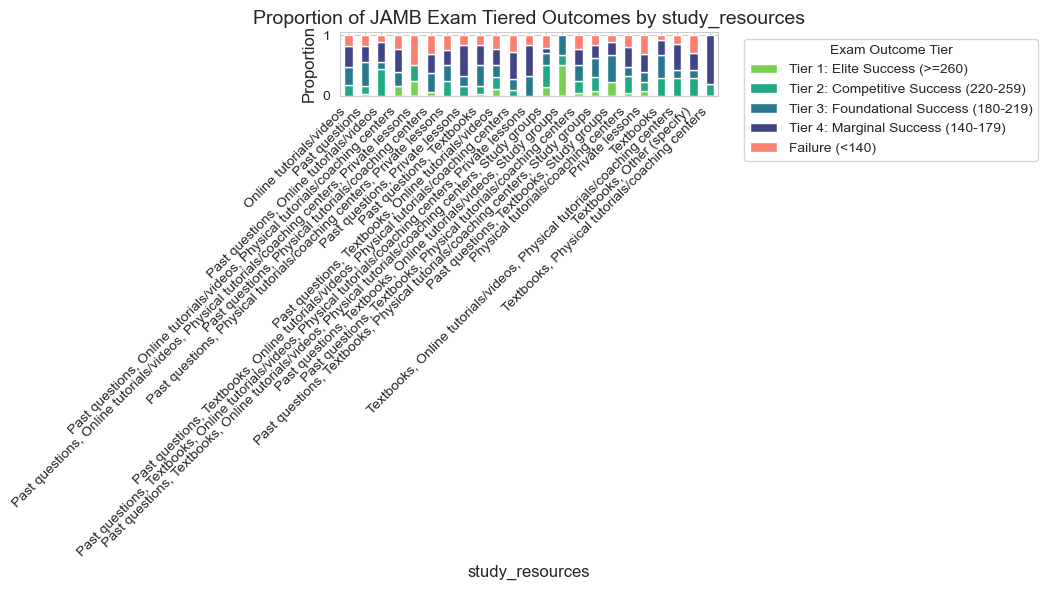

In [115]:
# --- Socio-economic Factors ---
# Special handling for missing values in these columns for EDA output readability
# Now, Guardian Education Level and Household Dependents are already Categorical Dtype,
# so their NaNs are pd.NA. fillna('Unknown') works by *adding* 'Unknown' as a category
# and then filling the NaNs.
print("\nAnalysis of 'guardian_education_level' vs. 'exam_outcome_tiered':")
temp_df_guardian_eda = df.copy()
# The 'Unknown' category is already included in the categorical dtype during load.
temp_df_guardian_eda['guardian_education_level'] = temp_df_guardian_eda['guardian_education_level'].fillna('Unknown')
analyze_categorical_vs_tiered_outcome(temp_df_guardian_eda, 'guardian_education_level')

print("\nAnalysis of 'household_dependents' vs. 'exam_outcome_tiered':")
temp_df_dependents_eda = df.copy()
# The 'Unknown' category is already included in the categorical dtype during load.
temp_df_dependents_eda['household_dependents'] = temp_df_dependents_eda['household_dependents'].fillna('Unknown')
analyze_categorical_vs_tiered_outcome(temp_df_dependents_eda, 'household_dependents')

# Study Resources: This column is complex due to multi-select.
# For EDA analysis, as per sample, we directly pass it, noting it might show complex categories.
# For ML, we will one-hot encode it fully.
print("\nAnalysis of 'study_resources' vs. 'exam_outcome_tiered':")
analyze_categorical_vs_tiered_outcome(df, 'study_resources')

## **3. Data Preprocessing for Predictive Modeling**

In [116]:

df_model = df.copy() # Use the df with 'exam_outcome_tiered'

# Handle Missing Values for Modeling (using sample's simple fillna for these specified columns before get_dummies)
# These columns are now CategoricalDtype and 'Unknown' is already in their categories.
df_model['guardian_education_level'] = df_model['guardian_education_level'].fillna('Unknown')
df_model['household_dependents'] = df_model['household_dependents'].fillna('Unknown')

df_model['biggest_challenge'].fillna('Unknown', inplace=True) # simple string fillna

C:\Users\Nel\AppData\Local\Temp\ipykernel_4416\3555107119.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['biggest_challenge'].fillna('Unknown', inplace=True) # simple string fillna


In [117]:
# Prepare Target Variable: Convert 'exam_outcome_tiered' to numerical (0 to 4) using LabelEncoder 
le_tiered = LabelEncoder()
df_model['exam_outcome_tiered_encoded'] = le_tiered.fit_transform(df_model['exam_outcome_tiered'])
print("Exam Outcome Tiered Mapping (for modeling):")

Exam Outcome Tiered Mapping (for modeling):


In [118]:
# Ensure consistent order by remapping based on tier_order
label_mapping = {name: le_tiered.transform([name])[0] for name in tier_order}
print(label_mapping)

{'Tier 1: Elite Success (>=260)': 1, 'Tier 2: Competitive Success (220-259)': 2, 'Tier 3: Foundational Success (180-219)': 3, 'Tier 4: Marginal Success (140-179)': 4, 'Failure (<140)': 0}


In [119]:
# Features to exclude from X (identifiers, original score, string outcomes, text fields) 
cols_to_drop_for_X = [
    'student_id',
    'jamb_score_most_recent',
    'exam_outcome_tiered', # String tiered outcome
    'exam_outcome_tiered_encoded', # This is our y_tiered
    'biggest_challenge', # Qualitative, not directly used as feature
    'advice_to_future_candidate' # Qualitative, not directly used as feature
]

# Identify categorical columns for one-hot encoding 
# This selects all 'object' and 'category' dtype columns AFTER dropping the ones above.
# It will include study_hours_per_day, household_dependents, study_resources, etc.
categorical_cols_for_X_ml = df_model.drop(columns=cols_to_drop_for_X).select_dtypes(include=['object', 'category']).columns.tolist()

# Define features (X_tiered) and target (y_tiered)
X_tiered = df_model.drop(columns=cols_to_drop_for_X)
y_tiered = df_model['exam_outcome_tiered_encoded']

# Apply One-Hot Encoding to the selected categorical features 
# Note: This will handle all categorical (object/category) features identified.
X_tiered = pd.get_dummies(X_tiered, columns=categorical_cols_for_X_ml, drop_first=True) # drop_first avoids multicollinearity

print("\nFirst 5 rows of preprocessed features (X_tiered):")
print(X_tiered.head())
print(f"Shape of preprocessed features (X_tiered): {X_tiered.shape}")
print(f"Shape of target (y_tiered): {y_tiered.shape}")


First 5 rows of preprocessed features (X_tiered):
   jamb_attempts_count  jamb_year_most_recent  school_type_Other (specify)  \
0                    4                   2025                        False   
1                    1                   2022                        False   
2                    2                   2022                        False   
3                    1                   2022                        False   
4                    1                   2022                        False   

   school_type_Private  school_type_Public  school_type_Public/Government  \
0                 True               False                          False   
1                 True               False                          False   
2                False               False                           True   
3                 True               False                          False   
4                False               False                           True   

   school_locatio

In [120]:
# Save preprocessed data (optional, for documentation)
X_tiered.to_csv('JAMB_Preprocessed_Features_Tiered.csv', index=False)
y_tiered.to_csv('JAMB_Target_Outcome_Tiered.csv', index=False)
print("\nPreprocessed tiered features saved to 'JAMB_Preprocessed_Features_Tiered.csv'")
print("Tiered target outcome saved to 'JAMB_Target_Outcome_Tiered.csv'")


Preprocessed tiered features saved to 'JAMB_Preprocessed_Features_Tiered.csv'
Tiered target outcome saved to 'JAMB_Target_Outcome_Tiered.csv'


## **4. Predictive Modeling - Multi-class Classification (Tiered Outcomes)**

In [123]:

# Split the data into training and testing sets 
X_train_tiered, X_test_tiered, y_train_tiered, y_test_tiered = train_test_split(
    X_tiered, y_tiered, test_size=0.2, random_state=42, stratify=y_tiered) # Stratify to maintain class proportions


print("\nDistribution of Tiered Exam Outcomes in Test Set (Encoded Values):")
print(y_test_tiered.value_counts())


Distribution of Tiered Exam Outcomes in Test Set (Encoded Values):
exam_outcome_tiered_encoded
4    26
3    25
0    18
2    16
1     5
Name: count, dtype: int64


In [124]:
# To see human-readable distribution:
decoded_y_test_counts = y_test_tiered.map({v: k for k, v in label_mapping.items()}).value_counts().reindex(tier_order)
print("\nDistribution of Tiered Exam Outcomes in Test Set (Human-Readable):")
print(decoded_y_test_counts)


Distribution of Tiered Exam Outcomes in Test Set (Human-Readable):
exam_outcome_tiered_encoded
Tier 1: Elite Success (>=260)              5
Tier 2: Competitive Success (220-259)     16
Tier 3: Foundational Success (180-219)    25
Tier 4: Marginal Success (140-179)        26
Failure (<140)                            18
Name: count, dtype: int64


In [125]:
# Initialize and Train Random Forest Classifier 
rf_classifier_tiered = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_tiered.fit(X_train_tiered, y_train_tiered)
print("Random Forest Classifier trained successfully for tiered outcomes.")

Random Forest Classifier trained successfully for tiered outcomes.


In [127]:
# Make predictions
y_pred_tiered = rf_classifier_tiered.predict(X_test_tiered)
print("\nPrediction completed")


Prediction completed


In [128]:
# Evaluate the model 
print("\n--- Multi-class Model Evaluation (Tiered Outcomes) ---")
accuracy_tiered = accuracy_score(y_test_tiered, y_pred_tiered)
print(f"Accuracy: {accuracy_tiered:.4f}")


--- Multi-class Model Evaluation (Tiered Outcomes) ---
Accuracy: 0.2889


In [129]:
print("\nClassification Report (Tiered Outcomes):")
# Use target_names to map encoded labels back to human-readable tier names
print(classification_report(y_test_tiered, y_pred_tiered, target_names=tier_order, zero_division=0))


Classification Report (Tiered Outcomes):
                                        precision    recall  f1-score   support

         Tier 1: Elite Success (>=260)       0.22      0.28      0.24        18
 Tier 2: Competitive Success (220-259)       0.00      0.00      0.00         5
Tier 3: Foundational Success (180-219)       0.33      0.12      0.18        16
    Tier 4: Marginal Success (140-179)       0.30      0.32      0.31        25
                        Failure (<140)       0.35      0.42      0.39        26

                              accuracy                           0.29        90
                             macro avg       0.24      0.23      0.22        90
                          weighted avg       0.29      0.29      0.28        90



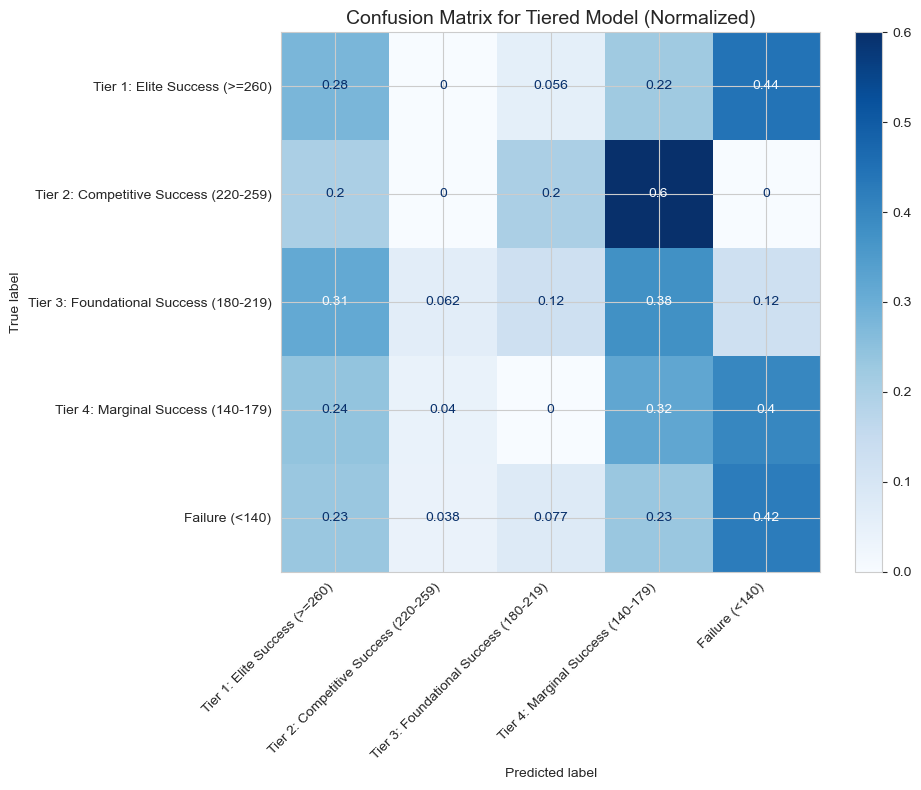

In [130]:
# Plot Confusion Matrix
fig_cm_tiered, ax_cm_tiered = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test_tiered, y_pred_tiered, cmap='Blues', ax=ax_cm_tiered, normalize='true',
                                         display_labels=tier_order) # Use tier_order for labels
ax_cm_tiered.set_title('Confusion Matrix for Tiered Model (Normalized)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [131]:
# Feature Importance 
feature_importances_tiered = rf_classifier_tiered.feature_importances_
features_tiered = X_tiered.columns
importance_df_tiered = pd.DataFrame({'Feature': features_tiered, 'Importance': feature_importances_tiered})
importance_df_tiered = importance_df_tiered.sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances for Tiered Model:")
print(importance_df_tiered.head(10))


Top 10 Feature Importances for Tiered Model:
                                              Feature  Importance
1                               jamb_year_most_recent    0.055830
0                                 jamb_attempts_count    0.031503
48                  guardian_education_level_Tertiary    0.031317
8                                         gender_Male    0.027239
39                       attended_extra_tutorials_Yes    0.026355
45                        study_plan_adherence_Always    0.026070
70  arrived_early_exam_center_Yes, significantly e...    0.024341
67                        quality_of_instruction_Good    0.023668
65                        quality_of_instruction_Poor    0.023295
7                               school_location_Urban    0.022990


## 5. **Forecasting Aggregate Success and Failure Rates (2026-2030)**
* For forecasting, we revert to the simple Success/Failure from original binary analysis
* This part strictly follows (Linear Regression on binary Success/Failure proportions).

In [132]:
# Re-create simple binary outcome based on score (if not already present or updated from previous runs)
# Assuming Success >= 200, Failure < 200 as per common threshold and sample code's original check
df['exam_outcome_binary'] = df['jamb_score_most_recent'].apply(lambda x: 'Success' if x >= 200 else 'Failure')

outcome_by_year_binary = df.groupby(['jamb_year_most_recent', 'exam_outcome_binary']).size().unstack(fill_value=0)
outcome_by_year_binary_proportions = outcome_by_year_binary.apply(lambda x: x / x.sum(), axis=1)

historical_proportions_df_binary = outcome_by_year_binary_proportions.reset_index()

# Ensure 'Success' and 'Failure' columns exist for all years, fill 0 if not
if 'Success' not in historical_proportions_df_binary.columns: historical_proportions_df_binary['Success'] = 0.0
if 'Failure' not in historical_proportions_df_binary.columns: historical_proportions_df_binary['Failure'] = 0.0

X_forecast_year = historical_proportions_df_binary[['jamb_year_most_recent']]
y_success_forecast = historical_proportions_df_binary['Success']
y_failure_forecast = historical_proportions_df_binary['Failure']

# Train Linear Regression models for Success and Failure proportions
from sklearn.linear_model import LinearRegression # Ensure LinearRegression is imported

model_success = LinearRegression()
model_success.fit(X_forecast_year, y_success_forecast)

model_failure = LinearRegression()
model_failure.fit(X_forecast_year, y_failure_forecast)

future_years_array = np.array([2026, 2027, 2028, 2029, 2030]).reshape(-1, 1)

forecasted_success_proportions = model_success.predict(future_years_array)
forecasted_failure_proportions = model_failure.predict(future_years_array)

forecast_df_binary = pd.DataFrame({
    'jamb_year_most_recent': future_years_array.flatten(),
    'Success': forecasted_success_proportions,
    'Failure': forecasted_failure_proportions
})

# Combine historical and forecasted proportions for plotting
full_proportions_df_binary = pd.concat([historical_proportions_df_binary, forecast_df_binary], ignore_index=True)

# Ensure proportions sum to 1 and are within [0, 1] bounds (due to linear regression, they might slightly deviate)
# This step also normalizes them to sum to 1 in case of minor deviations from LR.
full_proportions_df_binary['Success'] = np.clip(full_proportions_df_binary['Success'], 0, 1)
full_proportions_df_binary['Failure'] = np.clip(full_proportions_df_binary['Failure'], 0, 1)
full_proportions_df_binary['Total'] = full_proportions_df_binary['Success'] + full_proportions_df_binary['Failure']
# Re-normalize if sum is not 1 (only if total is not zero to avoid division by zero)
full_proportions_df_binary['Success'] = full_proportions_df_binary.apply(lambda row: row['Success'] / row['Total'] if row['Total'] != 0 else 0, axis=1)
full_proportions_df_binary['Failure'] = full_proportions_df_binary.apply(lambda row: row['Failure'] / row['Total'] if row['Total'] != 0 else 0, axis=1)

full_proportions_df_binary.drop(columns='Total', inplace=True)


print("\nForecasted Success and Failure Proportions (2026-2030):")
print(forecast_df_binary)


Forecasted Success and Failure Proportions (2026-2030):
   jamb_year_most_recent   Success   Failure
0                   2026  0.416412  0.583588
1                   2027  0.422315  0.577685
2                   2028  0.428218  0.571782
3                   2029  0.434121  0.565879
4                   2030  0.440024  0.559976


C:\Users\Nel\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Nel\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


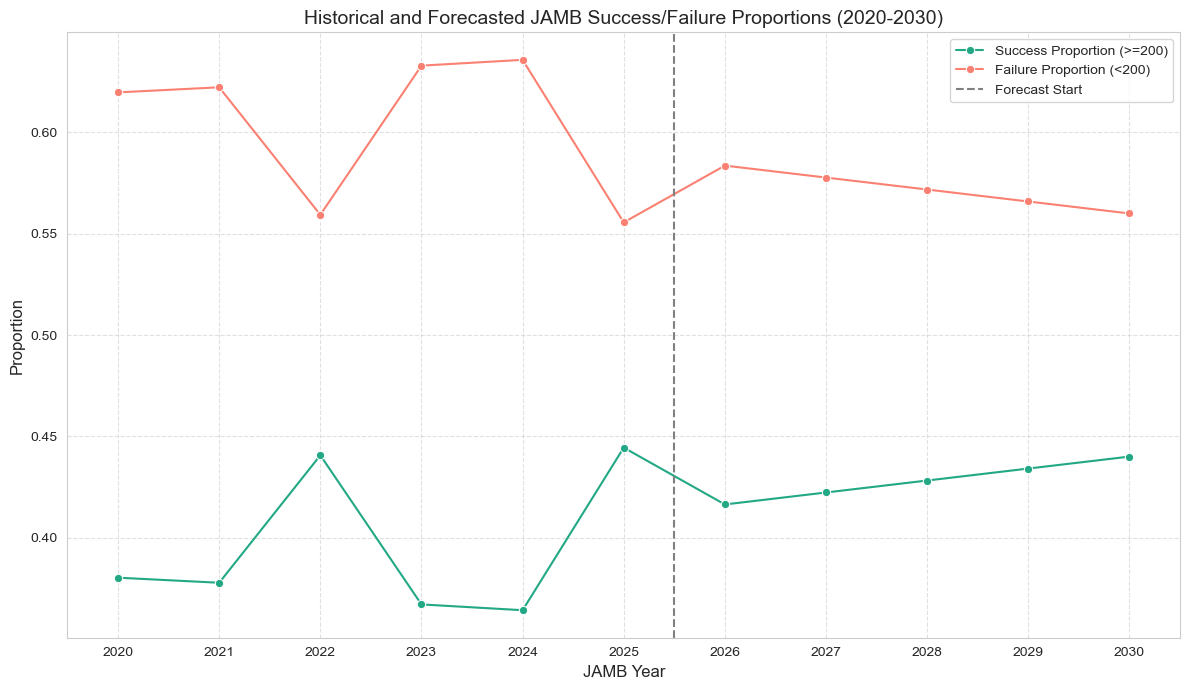


Historical and Forecasted Proportions saved to 'JAMB_Historical_and_Forecasted_Proportions.csv'

--- End of JAMB Performance Analysis & Prediction ---


In [134]:
# Plotting the historical and forecasted trends 
plt.figure(figsize=(12, 7))
sns.lineplot(data=full_proportions_df_binary, x='jamb_year_most_recent', y='Success', label='Success Proportion (>=200)', marker='o', color=colors_tiered_new['Tier 2: Competitive Success (220-259)']) # Using a shade of green
sns.lineplot(data=full_proportions_df_binary, x='jamb_year_most_recent', y='Failure', label='Failure Proportion (<200)', marker='o', color=colors_tiered_new['Failure (<140)']) # Using salmon

plt.axvline(x=2025.5, color='gray', linestyle='--', label='Forecast Start') # Mark forecast start

plt.title('Historical and Forecasted JAMB Success/Failure Proportions (2020-2030)', fontsize=14)
plt.xlabel('JAMB Year', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(np.arange(2020, 2031, 1)) # Ensure all years are ticks
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('jamb_forecasted_proportions_2020_2030.png')
plt.show()

# Save the full proportions DataFrame
full_proportions_df_binary.to_csv('JAMB_Historical_and_Forecasted_Proportions.csv', index=False)
print("\nHistorical and Forecasted Proportions saved to 'JAMB_Historical_and_Forecasted_Proportions.csv'")

print("\n--- End of JAMB Performance Analysis & Prediction ---")